In [10]:
# Feature Engineering for Water Pump Classification
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.errors import SettingWithCopyWarning

# Add the 'src' folder to the Python path
sys.path.append(os.path.abspath('../src'))
from cleaning_func import pumpit_clean

# Load dataset (adjust path as needed)
data_path = '../data/train.csv'
labels_path = '../data/train_labels.csv' 

df = pd.read_csv(data_path)
labels = pd.read_csv(labels_path)
df = pumpit_clean(df)
df.shape


warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))

NameError: name 'pd' is not defined

In [9]:
print(df.isna().sum())
print(df.head())

id                           0
amount_tsh                   0
date_recorded                0
funder                    3637
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     2
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3878
scheme_name              28810
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_



# Ticket 2.1.4: Create feature interaction terms if appropriate

* Generate interaction terms between related features
* Test interaction terms for predictive value



In [10]:
import statsmodels.api as sm
#  Choose  features
x = df.copy()
x = x.drop(columns=['longitude','latitude'])
#  Prepare target
y = labels['status_group'].replace({'functional':2,'non functional':0,'functional needs repair':0.7})

x = sm.add_constant(x)
mod1 = sm.OLS(y,x)
results = mod1.fit()
print(results.summary2())
print(x.describe().T)

C:\Users\Fatemeh Ebrahimi\AppData\Local\Temp\ipykernel_15848\693091814.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = labels['status_group'].replace({'functional':2,'non functional':0,'functional needs repair':0.7})
D:\script\Datacircle\water_pumps\.venv\lib\site-packages\numpy\_core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
D:\script\Datacircle\water_pumps\.venv\lib\site-packages\numpy\_core\_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

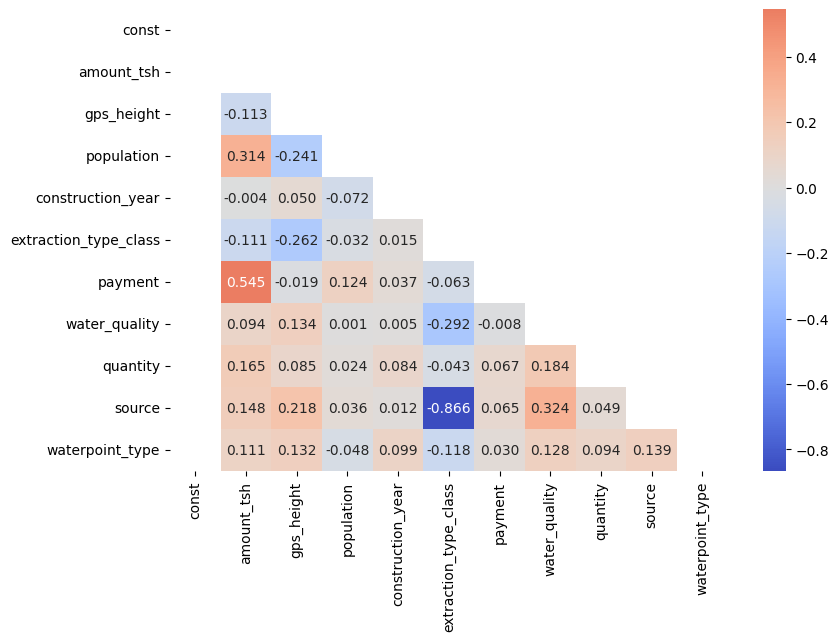

In [22]:

from scipy.stats import ttest_ind, kruskal, chi2_contingency

corr = x.corr(method='spearman') # returns a dataframe with the correlation values
matrix = np.triu(corr) # sets all the values of the lower triangle (under the main diagonal) to 0 (= False)

fig, ax = plt.subplots(1,1, figsize=(9,6))

sns.heatmap(
    corr,  # the data for the heatmap
    annot=True,  # show the actual values of correlation
    cmap='coolwarm',  # provide the 'seismic' colormap
    center=0,  # specify the value at which to center the colormap
    fmt='.3f', # specify the format for the annotation 
    mask=matrix # hides the values where mask = True (= upper triangle)
           )
plt.show()

In [9]:
x['tshXpayment'] = x.amount_tsh * x.payment
x['extractXsource'] = x.extraction_type_class * x.source
x['popXtsh'] = x.population * x.amount_tsh
x['popXquant'] = x.population * x.quantity
x['popXsource'] = x.population * x.source
x['extractXheight'] = x.extraction_type_class * x.gps_height
x['typeXsource'] = x.waterpoint_type * x.source
x['typeXyear'] = x.waterpoint_type * x.construction_year
x['yearXpop'] = x.construction_year * x.population
x['quantXsource'] = x.quantity * x.source
x['yearsq'] = np.sqrt(x.construction_year + 1) 

# model with interactions
mod2 = sm.OLS(y,x)
results2 = mod2.fit()
print(results2.summary2())
# print(x.describe().T)

                   Results: Ordinary least squares
Model:                OLS              Adj. R-squared:     0.259      
Dependent Variable:   status_group     AIC:                145552.3497
Date:                 2025-05-07 19:57 BIC:                145750.1748
No. Observations:     59400            Log-Likelihood:     -72754.    
Df Model:             21               F-statistic:        987.3      
Df Residuals:         59378            Prob (F-statistic): 0.00       
R-squared:            0.259            Scale:              0.67850    
----------------------------------------------------------------------
                       Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
----------------------------------------------------------------------
const                  1.9455   1.2522   1.5537 0.1203 -0.5088  4.3997
amount_tsh             1.3760   0.4685   2.9371 0.0033  0.4577  2.2942
gps_height             0.2450   0.0312   7.8597 0.0000  0.1839  0.3062
population             0.0

# Takeaway
Several interactions look promising. As one might expect, high `population` and low `quantity` seem to be bad for functionality (negative interaction). `waterpoint_type` and `source` also produce a large and highly signficant effect, as do `quantity` and `source`. I would prefer to keep all 3. Other notable interactions, in order of interest, are:

* `construction_year` and `population`
* `waterpoint_type` and `construction_year`
* `population` and `source`
* `extraction_type_class` and `gps_height`

I would advocate including the first three in our model, consider an extended model with 5, and try all 7 if time permits.

Afterthought: adding the square root of the (amended for numerical reasons) 

In [9]:
# Feature Engineering for Water Pump Classification

def pumpit_clean(df):
    # ``` This function requires: numpy, pandas, os,
    # ```
    import pandas as pd
    import numpy as np
    import os
    import matplotlib.pyplot as plt
    import seaborn as sns

    # handle extra imports here
    from sklearn.preprocessing import MinMaxScaler 
    from sklearn.preprocessing import LabelEncoder

    ## Numerical Variables
    
    # amount_tsh: cap at 15000
    df['amount_tsh'] = df['amount_tsh'].apply(lambda x: min(x, 15000))
    # might want to replace this with bins
    scaler = MinMaxScaler()
    df['amount_tsh'] = scaler.fit_transform(df[['amount_tsh']]) # names kept consistent
    # gps_height 
    # # Replace invalid gps_height values (e.g. 0 or negative)
    df['gps_height'] = df['gps_height'].apply(lambda x: np.nan if x <= 0 else x) 
    # Fill using median per basin
    df['gps_height'] = df.groupby('basin')['gps_height'].transform(
        lambda x: x.fillna(x.median())
    )
    # Fill any still missing using region median
    df['gps_height'] = df.groupby('region')['gps_height'].transform(
        lambda x: x.fillna(x.median())
    )
    df['gps_height'] = scaler.fit_transform(df[['gps_height']])

    # location:
    df['longitude'] = df['longitude'].replace(0, np.nan)
    df['latitude'] = df['latitude'].where(df['latitude'] < -0.5, np.nan) # too close to the equator
    for i in ['latitude','longitude']:
        df[i] = df.groupby('lga')[i].transform(lambda x: x.fillna(x.median))
        df[i] = df.groupby('region')[i].transform(lambda x: x.fillna(x.median))
        
    # Fill population using median by district_code
    df['population'] = df.groupby('lga')['population'].transform(
        lambda x: x.fillna(x.median())
    )
    # Fill any still missing with median by region, then overall median
    df['population'] = df.groupby('region')['population'].transform(
        lambda x: x.fillna(x.median())
    )
    df['population'] = df['population'].fillna(df.population.median)
    # Bin the outcome, see how it behaves
    df['population'] = pd.cut(df['population'], [-1,1,25,90,160,260,9999999], labels=[0,0.1,0.2,0.4,0.6,0.9])
    df['population'] = df['population'].astype(float)
    # Construction year ??
    df['construction_year'] = df['construction_year'].replace(0, np.nan) 
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df['recorded_year'] = df['date_recorded'].dt.year
    #Impute using region + installer
    df['construction_year'] = df.groupby(['region', 'installer'])['construction_year'].transform(
        lambda x: x.fillna(x.median())
    )
    #Impute using region only (for rows still missing)
    df['construction_year'] = df.groupby('region')['construction_year'].transform(
        lambda x: x.fillna(x.median())
    )
    #Use recorded year - 5
    df['construction_year'] = df['construction_year'].fillna(df['recorded_year'] - 5)
    df['construction_year'] = scaler.fit_transform(df[['construction_year']])

    ### Encode categorical variables
    
    # Encode 'quantity' (and typo fix: 'insufficent' -> 'insufficient')
    df['quantity'] = df['quantity'].replace({
        'enough': 1,
        'seasonal': 0.6,
        'insufficient': 0.4,
        'dry': 0,
        'unknown': 0
    })
    # Encode 'water_quality' as binary: good = 1, else 0
    df['water_quality'] = np.where(df['water_quality'] == 'soft', 1, 0)
    # Encode 'waterpoint_type' (1 = preferred type, 0 = everything else)
    preferred_waterpoint = ['hand pump', 'communal standpipe']
    df['waterpoint_type'] = df['waterpoint_type'].apply(lambda x: 1 if x in preferred_waterpoint else 0)
    # Encode 'payment' as binary: never pay = 0, else = 1
    df['payment'] = np.where(df['payment'] == 'never pay', 0, 1) 
    # Encode 'source' (1 = preferred sources, 0 = everything else)
    preferred_sources = ['spring', 'river', 'rainwater harvesting']
    df['source'] = df['source'].apply(lambda x: 1 if x in preferred_sources else 0)
    # Encode 'payment' as binary: never pay = 0, else = 1
    df['extraction_type_class'] = np.where(df['extraction_type_class'] == 'gravity', 0, 1)
    
    #  Drop other columns and only keep these:
    df = df[['amount_tsh',
             'gps_height',
             'longitude',
             'latitude',
             'population',
             'construction_year',
             'extraction_type_class',
             'payment',
            'water_quality',
            'quantity',
            'source',
            'waterpoint_type',
       ]]

    return df 
